In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import time

In [2]:
TIMESTEPS = 100_000

In [15]:
def update_a(previous_state):
    import math
    a = b = c = d = e = 100.0
    return previous_state['a'] * abs(math.cos(previous_state['a']))

def update_b(previous_state):
    return previous_state['b'] + 1

states = {
    'a': 1.0,
    'b': 2.0
}

psubs = [
    {
        'policies': {},
        'updates': {
            'a': update_a
        }
    },
    {
        'policies': {},
        'updates': {
            'b': update_b
        }
    }
]

In [16]:
import output.rad_cad as rc

time_profile = []

for i in range(8):
    timesteps = 10**i
    start = time.time()
    data_rc = rc.run(timesteps, states, psubs)
    end = time.time()
    duration = end - start
#     print(duration)
    time_profile.append({'timesteps': timesteps, 'duration': duration})

<AxesSubplot:xlabel='timesteps'>

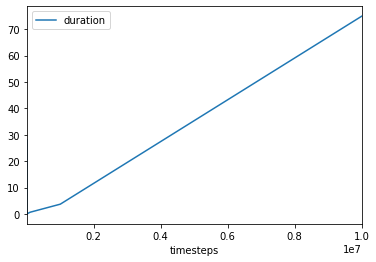

In [17]:
df = pd.DataFrame(time_profile)
df.plot(x='timesteps', y='duration')

---

In [77]:
result = [states]

def run():
    for i in range(TIMESTEPS):
        previous_state = result[-1]
        next_state = {}
        for psub in psubs:
            for state in psub['updates']:
                next_state.update({
                    state: psub['updates'][state](previous_state)
                })
        result.append(next_state)
    return result

start = time.time()
data = run()
end = time.time()
print(end - start)

df = pd.DataFrame(data)
df

0.17743897438049316


,a,b
0,1.000000,2.0
1,0.540302,3.0
2,0.463338,4.0
3,0.414486,5.0
4,0.379389,6.0
...,...,...
99996,0.003162,99998.0
99997,0.003162,99999.0
99998,0.003162,100000.0
99999,0.003162,100001.0


---

In [18]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

In [24]:
def update_a(params, substep, state_history, previous_state, policy_input):
    import math
    a = b = c = d = e = 100.0
    return 'a', previous_state['a'] * abs(math.cos(previous_state['a']))

def update_b(params, substep, state_history, previous_state, policy_input):
    return 'b', previous_state['b'] + 1

states = {
    'a': 1.0,
    'b': 2.0
}

psubs = [
    {
        'policies': {},
        'variables': {
            'a': update_a
        }
    },
    {
        'policies': {},
        'variables': {
            'b': update_b
        }
    }
]

In [25]:
from cadCAD import configs
del configs[:] # Clear any prior configs

config = {
    "N": 1,
    "T": range(TIMESTEPS),
#     "M": {}
}

c = config_sim(config)

exp = Experiment()
exp.append_configs(
    initial_state = states,
    partial_state_update_blocks = psubs,
    sim_configs = c
)

In [26]:
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

In [27]:
simulation = Executor(exec_context=local_mode_ctx, configs=configs)

In [32]:
%%capture
time_profile_cadcad = []

for i in range(7):
    timesteps = 10**i
    
    from cadCAD import configs
    del configs[:] # Clear any prior configs

    config = {
        "N": 1,
        "T": range(timesteps),
    #     "M": {}
    }

    c = config_sim(config)

    exp = Experiment()
    exp.append_configs(
        initial_state = states,
        partial_state_update_blocks = psubs,
        sim_configs = c
    )
    
    exec_mode = ExecutionMode()
    local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
    
    simulation = Executor(exec_context=local_mode_ctx, configs=configs)
    
    start = time.time()

    data, tensor_field, sessions = simulation.execute()

    end = time.time()
    duration = end - start
    time_profile_cadcad.append({'timesteps': timesteps, 'duration': duration})

<AxesSubplot:xlabel='timesteps'>

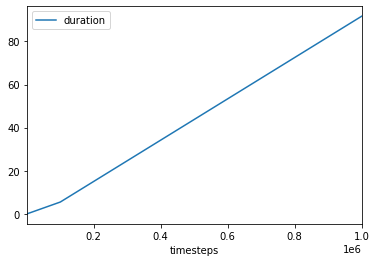

In [33]:
df = pd.DataFrame(time_profile_cadcad)
df.plot(x='timesteps', y='duration')

In [93]:
start = time.time()
data, tensor_field, sessions = simulation.execute()
end = time.time()
print(end - start)

df = pd.DataFrame(data)
df


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100000, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 4.96s
4.976506948471069


,a,b,simulation,subset,run,substep,timestep
0,1.000000,2.0,0,0,1,0,0
1,0.540302,2.0,0,0,1,1,1
2,0.540302,3.0,0,0,1,2,1
3,0.463338,3.0,0,0,1,1,2
4,0.463338,4.0,0,0,1,2,2
...,...,...,...,...,...,...,...
199996,0.003162,100000.0,0,0,1,2,99998
199997,0.003162,100000.0,0,0,1,1,99999
199998,0.003162,100001.0,0,0,1,2,99999
199999,0.003162,100001.0,0,0,1,1,100000


---

<AxesSubplot:xlabel='timesteps'>

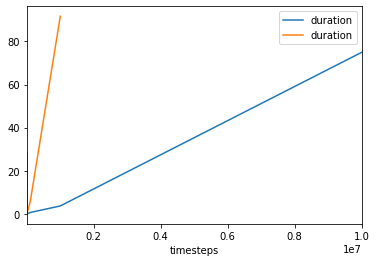

In [35]:
df_rc = pd.DataFrame(time_profile)
df_cc = pd.DataFrame(time_profile_cadcad)

ax = df_rc.plot(x='timesteps', y='duration')
df_cc.plot(ax=ax, x='timesteps', y='duration')

In [43]:
time_profile_cadcad[6]['duration']/time_profile[6]['duration']

24.79988542589665